https://towardsdatascience.com/a-practitioners-guide-to-natural-language-processing-part-i-processing-understanding-text-9f4abfd13e72

### Data scraped page-by-page from Yelp to avoid violating Yelp's TOS, then processed into page-specific DFs using variations on this code:

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import re 

# For reviews that Yelp includes in the ratings calculations and main review page:
r = requests.get('https://www.yelp.com/biz/zazie-san-francisco')
html = r.text
soup = BeautifulSoup(html, "html5lib")
author = soup.find_all(itemprop = 'author')
date = soup.find_all(itemprop = 'datePublished')
stars = soup.find_all(itemprop = 'ratingValue')
review_body = soup.find_all(itemprop = 'description')
df1 = pd.DataFrame({'author':author,'date':date,'stars':stars[1:],'review_body':review_body})

for i in range(len(df1)):
    df1.author[i] = re.sub('<meta content="','',str(df1.author[i]))
    df1.author[i] = re.sub('" itemprop="author"/>','',str(df1.author[i]))
    df1.date[i] = re.sub('<meta content="','',str(df1.date[i]))
    df1.date[i] = re.sub('" itemprop="datePublished"/>','',str(df1.date[i]))
    df1.stars[i] = re.sub('<meta content="','',str(df1.stars[i]))
    df1.stars[i] = re.sub('" itemprop="ratingValue"/>','',str(df1.stars[i]))
    df1.review_body[i] = re.sub('<p itemprop="description">','',str(df1.review_body[i]))
    df1.review_body[i] = re.sub('</p>','',str(df1.review_body[i]))

print(df1.shape)
df1.head()

# For reviews the Yelp excludes from the ratings calcuations and main review page:
r = requests.get('https://www.yelp.com/not_recommended_reviews/zazie-san-francisco?not_recommended_start=10')
html = r.text
soup = BeautifulSoup(html, "html5lib")
author = soup.find_all(class_ = 'user-display-name') 
date = soup.find_all(class_ = 'rating-qualifier')
stars = soup.find_all(width = '84')
review_body = soup.find_all(lang = 'en') #use only review_body[1:]
df1 = pd.DataFrame({'author':author,'date':date,'stars':stars,'review_body':review_body[1:]})
df1.head()

for i in range(len(df1)):
    df1.author[i] = re.sub('<span class="user-display-name" ','',str(df1.author[i]))
    df1.author[i] = re.sub('</span>','',str(df1.author[i]))
    df1.date[i] = re.sub('<span class="rating-qualifier">','',str(df1.date[i]))
    df1.date[i] = re.sub('</span>','',str(df1.date[i]))
    df1.stars[i] = re.sub('<img alt="','',str(df1.stars[i]))
    df1.stars[i] = re.sub(' star rating" class="offscreen" height="303" src="https://s3-media2.fl.yelpcdn.com/assets/srv0/yelp_design_web/9b34e39ccbeb/assets/img/stars/stars.png" width="84"/>','',str(df1.stars[i]))
    df1.review_body[i] = re.sub('<p lang="en">','',str(df1.review_body[i]))
    df1.review_body[i] = re.sub('</p>','',str(df1.review_body[i]))

print(df1.shape)
df1

# To build a full df out of each type of review (separately):
dfs = [df1,df2,df3,df4] #many more df than provided in this example

DF = df40
for i in dfs:
    DF = DF.append(i, ignore_index=True)
    
print(DF.shape)
DF

### Then moving on to work with compiled reviews as below:

In [1]:
import numpy as np
import pandas as pd
import autopep8
import spacy
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
import re
from bs4 import BeautifulSoup
import unicodedata

In [3]:
nlp = spacy.load('en_core_web_md', parse=True, tag=True, entity=True)
#nlp_vec = spacy.load('en_vecs', parse = True, tag=True, #entity=True)
tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')
# stopword_list.append('zazie')
# stopword_list.append('food')
# stopword_list.append('egg')
# stopword_list.append('french')
# stopword_list.append('good')

In [4]:
included_reviews = pd.read_csv('/home/cynthiaorourke/Desktop/Yelp_Zazie/Lovina_reviews_included.csv')
print(included_reviews.shape)
included_reviews.head()

(273, 5)


,Unnamed: 0,author,date,stars,review_body
0,0,Stacey P.,2019-03-09,5.0,Thank you Yelp for recommending Lovina.\n\nMys...
1,1,Cathy H.,2019-03-05,5.0,Delicious local-feeling place! The daily focac...
2,2,Himanshu K.,2018-11-24,5.0,Amazing place\n\nDefinitely try the French Toa...
3,3,Sylvia E.,2019-03-02,5.0,Little gem in Calistoga! Delicious food and v...
4,4,Mary M.,2019-03-10,5.0,Great food and great service. The location is ...


### Functions built for text preprocessing:

In [5]:
def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text()
    return stripped_text

# strip_html_tags('<html><h2>Some important text</h2></html>')

In [7]:
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

# remove_accented_chars('Sómě Áccěntěd těxt')

In [8]:
CONTRACTION_MAP = {
"ain't": "is not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"I'd": "I would",
"I'd've": "I would have",
"I'll": "I will",
"I'll've": "I will have",
"I'm": "I am",
"I've": "I have",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have"
}

In [9]:
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

# expand_contractions("Y'all can't expand contractions I'd think")

In [10]:
def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

# remove_special_characters("Well this was fun! What do you think? 123#@!",remove_digits=True)

In [11]:
def simple_stemmer(text):
    ps = nltk.porter.PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text

# simple_stemmer("My system keeps crashing his crashed yesterday, ours crashes daily")

In [12]:
def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

# lemmatize_text("My system keeps crashing! his crashed yesterday, ours crashes daily")

In [13]:
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

# remove_stopwords("The, and, if are stopwords, computer is not")

In [14]:
def normalize_corpus(corpus, html_stripping=True, contraction_expansion=True,
                     accented_char_removal=True, text_lower_case=True, 
                     text_lemmatization=True, special_char_removal=True, 
                     stopword_removal=True, remove_digits=True):
    
    normalized_corpus = []
    # normalize each document in the corpus
    for doc in corpus:
        # strip HTML
        if html_stripping:
            doc = strip_html_tags(doc)
        # remove accented characters
        if accented_char_removal:
            doc = remove_accented_chars(doc)
        # expand contractions    
        if contraction_expansion:
            doc = expand_contractions(doc)
        # lowercase the text    
        if text_lower_case:
            doc = doc.lower()
        # remove extra newlines
        doc = re.sub(r'[\r|\n|\r\n]+', ' ',doc)
        # lemmatize text
        if text_lemmatization:
            doc = lemmatize_text(doc)
        # remove special characters and\or digits    
        if special_char_removal:
            # insert spaces between special characters to isolate them    
            special_char_pattern = re.compile(r'([{.(-)!}])')
            doc = special_char_pattern.sub(" \\1 ", doc)
            doc = remove_special_characters(doc, remove_digits=remove_digits)  
        # remove extra whitespace
        doc = re.sub(' +', ' ', doc)
        # remove stopwords
        if stopword_removal:
            doc = remove_stopwords(doc, is_lower_case=text_lower_case)
            
        normalized_corpus.append(doc)
        
    return normalized_corpus

In [15]:
# pre-process reviews text
included_reviews['review_cleaned'] = normalize_corpus(included_reviews['review_body'])
norm_corpus = list(included_reviews['review_cleaned'])

### Export and save locally to skip this preprocessing step in the future:

In [16]:
included_reviews.to_csv('/home/cynthiaorourke/Desktop/Yelp_Zazie/cleaned_inc_reviews.csv')

In [17]:
# create a basic pre-processed corpus, don't lowercase to get POS context
corpus = normalize_corpus(included_reviews['review_body'], text_lower_case=False, 
                          text_lemmatization=False, special_char_removal=False)

In [18]:
nltk.download('averaged_perceptron_tagger')

# demo for POS tagging for sample news headline
sentence = str(included_reviews.iloc[1].review_body)
sentence_nlp = nlp(sentence)

# POS tagging with Spacy 
spacy_pos_tagged = [(word, word.tag_, word.pos_) for word in sentence_nlp]
spacy_example = pd.DataFrame(spacy_pos_tagged, columns=['Word', 'POS tag', 'Tag type'])
spacy_example.head()

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/cynthiaorourke/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


,Word,POS tag,Tag type
0,Delicious,JJ,ADJ
1,local,RB,ADV
2,-,HYPH,PUNCT
3,feeling,VBG,VERB
4,place,NN,NOUN


In [19]:
# POS tagging with nltk
nltk_pos_tagged = nltk.pos_tag(sentence.split())
nltk_example = pd.DataFrame(nltk_pos_tagged, columns=['Word', 'POS tag'])
nltk_example.head()

,Word,POS tag
0,Delicious,JJ
1,local-feeling,JJ
2,place!,IN
3,The,DT
4,daily,JJ


### Skipping a lot of additional instructive NLP work in the tutorial here - come back to that.

In [20]:
from afinn import Afinn
af = Afinn()

In [21]:
# compute sentiment scores (polarity) and labels
sentiment_scores = [af.score(article) for article in corpus]
sentiment_category = ['positive' if score > 0 
                          else 'negative' if score < 0 
                              else 'neutral' 
                                  for score in sentiment_scores]
    
    
# sentiment statistics per news category
df = pd.DataFrame([list(included_reviews['stars']), sentiment_scores, sentiment_category]).T
df.columns = ['stars', 'sentiment_score', 'sentiment_category']
df['sentiment_score'] = df.sentiment_score.astype('float')
df.groupby(by=['stars']).describe()

sentiment_score                                                    
                count       mean        std   min  25%   50%    75%   max
stars                                                                    
1.0              24.0   0.375000   7.603274 -16.0 -4.0   0.0   3.25  19.0
2.0              13.0   2.076923   7.488453  -8.0 -4.0   2.0   9.00  14.0
3.0              17.0  12.470588   8.239521   0.0  9.0  10.0  22.00  25.0
4.0              55.0  15.636364  10.741687   2.0  7.5  13.0  20.00  55.0
5.0             164.0  15.957317  10.031454   1.0  9.0  14.0  20.00  54.0

### A higher mean indicates a more positive sentiment score, so this^ checks out.

In [22]:
# let's look at one of these cleaned reviews, vs the original:
print('raw:',included_reviews.iloc[0,4])
print('...')
print('cleaned:',included_reviews.iloc[0,5])

raw: Thank you Yelp for recommending Lovina.

Myself and two friends were hungry, out of town visitors, and clueless where to eat. With such glowing reviews figured it was well worth the shot! I would not have found it otherwise because I must admit when we parked behind the restaurant and there was little signage and it looked like a house I was skeptical.

My skepticism melted upon entering and being warmly greeted immediately. It was just damn nice. We were seated promptly and our server was charming, welcoming, and just delightful. 

I ordered the cheeseburger, my friend ordered the cheese sandwich, and my other friend ordered the eggs and bacon. I was quite impressed when the orders came out. The portions are huge! That grilled cheese was the thickest, cheesiest sandwich I've ever seen. It ooooooozed cheese! The bread was hearty. It was just giant! My cheeseburger was also amazing - a perfect bun to meat ratio. It was oh so juicy, perfectly seasoned, fantastic cheese, and so very 

In [23]:
# let's try vizualizing these scores:
import seaborn as sns 

fc = sns.factorplot(x="stars", hue="sentiment_category", 
                    data=df, kind="count", 
                    palette={"negative": "#FE2020", 
                             "positive": "#BADD07", 
                             "neutral": "#68BFF5"})

fc.fig.suptitle('Word counts by sentiment and stars')

/home/cynthiaorourke/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


Text(0.5, 0.98, 'Word counts by sentiment and stars')

In [24]:
pos_idx = df[(df.sentiment_score == 152)].index[0]
neg_idx = df[(df.sentiment_score == -62)].index[0]

print('Most negative review:', included_reviews.iloc[neg_idx][['date']][0], included_reviews.iloc[neg_idx][['author']][0])
print(included_reviews.iloc[neg_idx][['review_body']][0])
print()
print('Most positive review:', included_reviews.iloc[pos_idx][['date']][0], included_reviews.iloc[pos_idx][['author']][0])
print(included_reviews.iloc[pos_idx][['review_body']][0])

IndexError: index 0 is out of bounds for axis 0 with size 0

### Topic modeling

In [25]:
from tqdm import tqdm
import string
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import concurrent.futures
import time
import pyLDAvis.sklearn
from pylab import bone, pcolor, colorbar, plot, show, rcParams, savefig
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import os

# Plotly based imports for visualization
from plotly import tools
import plotly.plotly as py
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.figure_factory as ff

# spaCy based imports
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
!python -m spacy download en_core_web_lg


    Linking successful
    /home/cynthiaorourke/anaconda3/lib/python3.7/site-packages/en_core_web_lg
    -->
    /home/cynthiaorourke/anaconda3/lib/python3.7/site-packages/spacy/data/en_core_web_lg

    You can now load the model via spacy.load('en_core_web_lg')



In [26]:
# Creating a spaCy object
nlp = spacy.load('en_core_web_lg')

In [27]:
doc = nlp(included_reviews['review_body'][4])
spacy.displacy.render(doc, style='ent',jupyter=True)

In [28]:
punctuations = string.punctuation
stopwords = list(STOP_WORDS)

In [29]:
review = str(" ".join([i.lemma_ for i in doc]))

In [30]:
doc = nlp(review)
spacy.displacy.render(doc, style='ent',jupyter=True)
#no difference from above if we start with review_cleaned above, as review_cleaned has...
#... already been pre-processed 

In [32]:
# Parser for reviews
parser = English()
def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in stopwords and word not in punctuations ]
    mytokens = " ".join([i for i in mytokens])
    return mytokens

In [33]:
tqdm.pandas()
included_reviews['processed_reviews'] = included_reviews['review_body'].progress_apply(spacy_tokenizer)

100%|██████████| 273/273 [00:00<00:00, 531.36it/s]


In [34]:
# Creating a vectorizer
#now with custom stopwords
vectorizer = CountVectorizer(min_df=5, max_df=0.9, stop_words=stopwords, lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}')
data_vectorized = vectorizer.fit_transform(included_reviews['processed_reviews'])

In [35]:
# this is an arbitrary number:
NUM_TOPICS = 10

In [36]:
# Latent Dirichlet Allocation Model
lda = LatentDirichletAllocation(n_components=NUM_TOPICS, max_iter=10, learning_method='online',verbose=True)
data_lda = lda.fit_transform(data_vectorized)
#should cross-validation have been applied?

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


In [37]:
# Non-Negative Matrix Factorization Model
nmf = NMF(n_components=NUM_TOPICS)
data_nmf = nmf.fit_transform(data_vectorized) 

In [38]:
# Latent Semantic Indexing Model using Truncated SVD
lsi = TruncatedSVD(n_components=NUM_TOPICS)
data_lsi = lsi.fit_transform(data_vectorized)

In [39]:
# Functions for printing keywords for each topic
def selected_topics(model, vectorizer, top_n=10):
    for idx, topic in enumerate(model.components_):
        print("Topic %d:" % (idx))
        print([(vectorizer.get_feature_names()[i], topic[i])
                        for i in topic.argsort()[:-top_n - 1:-1]]) 

In [40]:
# Keywords for topics clustered by Latent Dirichlet Allocation
print("LDA Model:")
selected_topics(lda, vectorizer)

LDA Model:
Topic 0:
[('good', 21.54024739726834), ('great', 18.868579231011495), ('pork', 17.667937688413886), ('meal', 17.58798229341556), ('service', 16.962956950701884), ('look', 15.51739190200624), ('salad', 14.016430228500504), ('wine', 12.508622474663587), ('check', 9.991235444751776), ('steak', 9.908184404880942)]
Topic 1:
[('salad', 31.097732352840765), ('burger', 24.61516095823141), ('lunch', 17.21177418700636), ('delicious', 15.84808772817048), ('good', 15.476083266713228), ('like', 15.272293085872073), ('lamb', 15.01190236788844), ('order', 14.449603878617799), ('cheese', 14.27832876053908), ('veggie', 13.954544816279103)]
Topic 2:
[('quality', 10.387359468062664), ('great', 8.306557111373943), ('prepare', 7.941162144502909), ('ingredient', 6.84240716112206), ('juice', 6.834202450295102), ('house', 6.685890738368946), ('food', 6.219573379885604), ('good', 4.663918806048522), ('visit', 4.304674844013632), ('sauce', 3.971930713290532)]
Topic 3:
[('table', 45.96256822910255), (

In [41]:
# Keywords for topics clustered by Latent Semantic Indexing
print("NMF Model:")
selected_topics(nmf, vectorizer)

NMF Model:
Topic 0:
[('good', 4.93170501269609), ('like', 1.0542677527695916), ('little', 0.8478131939393064), ('fresh', 0.7067885346919296), ('delicious', 0.6932997824821783), ('lamb', 0.6418653244638269), ('cake', 0.6101357986049206), ('dish', 0.5625891620083696), ('dessert', 0.5554659712566453), ('flavor', 0.5233714927389642)]
Topic 1:
[('table', 3.8137574957505205), ('restaurant', 1.149542846511923), ('hostess', 0.8221785288184776), ('time', 0.588340267531055), ('dinner', 0.5549739234998489), ('open', 0.5411494105245515), ('ask', 0.4991661772554882), ('reservation', 0.48020148490687276), ('service', 0.462271680261953), ('leave', 0.3933941831394653)]
Topic 2:
[('coffee', 1.4544267543001002), ('toast', 0.9832221118662774), ('ask', 0.9524199962455645), ('french', 0.940065060338407), ('egg', 0.9036339198352078), ('order', 0.8374245134366021), ('waitress', 0.830982903769532), ('breakfast', 0.7503458432754931), ('feel', 0.7500349734087716), ('eat', 0.626189603683756)]
Topic 3:
[('love', 

In [42]:
# Keywords for topics clustered by Non-Negative Matrix Factorization
print("LSI Model:")
selected_topics(lsi, vectorizer)

LSI Model:
Topic 0:
[('food', 0.30442489920068927), ('good', 0.2592635113135372), ('come', 0.2167410015781488), ('calistoga', 0.20426061415936206), ('service', 0.1849178852860311), ('place', 0.18309310850512142), ('restaurant', 0.1793518885611151), ('table', 0.17242351832727038), ('great', 0.15365879581860287), ('time', 0.13571213994355877)]
Topic 1:
[('table', 0.7881140655090123), ('restaurant', 0.20096458886689464), ('hostess', 0.17232741474606655), ('open', 0.11142042703136071), ('ask', 0.10567942793316126), ('time', 0.0915799773878592), ('dinner', 0.09079149441208388), ('reservation', 0.08938121082688534), ('available', 0.08452813297807073), ('leave', 0.07766538542291636)]
Topic 2:
[('food', 0.3101632998661754), ('come', 0.22489955558125935), ('ask', 0.20990384254754627), ('coffee', 0.2022502559570986), ('love', 0.18198383766088075), ('waitress', 0.1594026527709431), ('wait', 0.15725420009726257), ('water', 0.1494563165850129), ('day', 0.14617707511800748), ('leave', 0.118036968816

In [43]:
pyLDAvis.enable_notebook()
dash = pyLDAvis.sklearn.prepare(lda, data_vectorized, vectorizer, mds='tsne')
dash

#

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
4      227.136108  255.518265       1        1  60.599056
3     -300.466614 -126.330116       2        1  11.211327
1      -62.760136  294.404022       3        1  11.051833
0       51.640743 -108.544739       4        1   6.487974
2     -126.197220   12.377857       5        1   3.182646
9       67.815948  106.009277       6        1   2.912438
5      284.433197  -14.518091       7        1   1.658389
8      195.434555 -273.106964       8        1   1.216746
7     -286.200958  166.584442       9        1   1.134764
6      -96.871574 -281.679657      10        1   0.544828, topic_info=     Category        Freq           Term       Total  loglift  logprob
term                                                                  
156   Default  130.000000          great  130.000000  30.0000  30.0000
141   Default  179.000000           food  179.000000  29.0000  29.0000
43    Default   54.000000      breakfast   54.000000  28.0000  28.0000
338   Default  132.000000        service  132.000000  27.0000  27.0000
70    Default   89.000000           come   89.000000  26.0000  26.0000
155   Default  182.000000           good  182.000000  25.0000  25.0000
377   Default   60.000000          table   60.000000  24.0000  24.0000
313   Default  107.000000     restaurant  107.000000  23.0000  23.0000
15    Default   55.000000            ask   55.000000  22.0000  22.0000
46    Default   45.000000         brunch   45.000000  21.0000  21.0000
95    Default   73.000000      delicious   73.000000  20.0000  20.0000
326   Default   66.000000          salad   66.000000  19.0000  19.0000
222   Default   50.000000           love   50.000000  18.0000  18.0000
230   Default   63.000000           meal   63.000000  17.0000  17.0000
52    Default  155.000000      calistoga  155.000000  16.0000  16.0000
9     Default   23.000000            amp   23.000000  15.0000  15.0000
260   Default   52.000000          order   52.000000  14.0000  14.0000
48    Default   30.000000         burger   30.000000  13.0000  13.0000
284   Default   31.000000           pork   31.000000  12.0000  12.0000
336   Default   36.000000          serve   36.000000  11.0000  11.0000
308   Default   24.000000      recommend   24.000000  10.0000  10.0000
189   Default   22.000000     ingredient   22.000000   9.0000   9.0000
60    Default   35.000000           chef   35.000000   8.0000   8.0000
426   Default   48.000000           wine   48.000000   7.0000   7.0000
396   Default   53.000000            try   53.000000   6.0000   6.0000
101   Default   62.000000         dinner   62.000000   5.0000   5.0000
278   Default  117.000000          place  117.000000   4.0000   4.0000
146   Default   46.000000          fresh   46.000000   3.0000   3.0000
90    Default   44.000000            day   44.000000   2.0000   2.0000
379   Default   32.000000          taste   32.000000   1.0000   1.0000
...       ...         ...            ...         ...      ...      ...
387   Topic10    0.082031           tiki    4.230445   1.2695  -6.2810
223   Topic10    0.079089          loved    4.171863   1.2469  -6.3175
118   Topic10    0.079623         excite    4.213527   1.2437  -6.3108
438   Topic10    0.081552          zazie    4.365320   1.2322  -6.2869
91    Topic10    0.081641         decent    4.447162   1.2148  -6.2858
356   Topic10    0.078197          spicy    4.272595   1.2117  -6.3289
11    Topic10    0.079743     appreciate    4.375271   1.2075  -6.3093
200   Topic10    0.081901  knowledgeable    4.550604   1.1950  -6.2826
166   Topic10    0.078851           head    4.406135   1.1893  -6.3206
266   Topic10    0.078462           park    4.386292   1.1888  -6.3255
243   Topic10    0.076178          music    4.268406   1.1865  -6.3550
405   Topic10    0.077105        veggies    4.329143   1.1845  -6.3429
349   Topic10    0.077790           soon    4.440887   1.1679  -6.

In [47]:
# Create Document - Topic Matrix
lda_output = lda.transform(data_vectorized)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ["cleaned_review" + str(i) for i in range(len(included_reviews['review_cleaned']))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

df_document_topic.head()
# Now get stars in there!!!

NameError: name 'best_lda_model' is not defined

In [45]:
df_document_topic = df_document_topic.reset_index(drop=False)

df_document_topic['stars'] = included_reviews['stars']
df_document_topic['text'] = included_reviews['review_body']

NameError: name 'df_document_topic' is not defined

In [ ]:
# df_document_topic.head(50)

In [ ]:
ax = sns.countplot(x='dominant_topic', hue='stars', data=df_document_topic)
#note that the 1-star reviews are clumping in topcs 4, 5, and to a lesser proportion 7
#5 and 7 are also heavy with 2-star reviews

In [ ]:
svd_2d = TruncatedSVD(n_components=2)
data_2d = svd_2d.fit_transform(data_vectorized)

In [ ]:
trace = go.Scattergl(
    x = data_2d[:,0],
    y = data_2d[:,1],
    mode = 'markers',
    marker = dict(
        color = '#FFBAD2',
        line = dict(width = 1)
    ),
    text = vectorizer.get_feature_names(),
    hovertext = vectorizer.get_feature_names(),
    hoverinfo = 'text' 
)
data = [trace]
iplot(data, filename='scatter-mode')

In [46]:
trace = go.Scattergl(
    x = data_2d[:,0],
    y = data_2d[:,1],
    mode = 'text',
    marker = dict(
        color = '#FFBAD2',
        line = dict(width = 1)
    ),
    text = vectorizer.get_feature_names()
)
data = [trace]
iplot(data, filename='text-scatter-mode')

NameError: name 'data_2d' is not defined

In [48]:
def spacy_bigram_tokenizer(phrase):
    doc = parser(phrase) # create spacy object
    token_not_noun = []
    notnoun_noun_list = []
    noun = ""

    for item in doc:
        if item.pos_ != "NOUN": # separate nouns and not nouns
            token_not_noun.append(item.text)
        if item.pos_ == "NOUN":
            noun = item.text
        
        for notnoun in token_not_noun:
            notnoun_noun_list.append(notnoun + " " + noun)

    return " ".join([i for i in notnoun_noun_list])

In [49]:
bivectorizer = CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True, ngram_range=(1,2))
bigram_vectorized = bivectorizer.fit_transform(included_reviews['processed_reviews'])

In [50]:
bi_lda = LatentDirichletAllocation(n_components=NUM_TOPICS, max_iter=10, learning_method='online',verbose=True)
data_bi_lda = bi_lda.fit_transform(bigram_vectorized)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


In [51]:
print("Bi-LDA Model:")
selected_topics(bi_lda, bivectorizer)

Bi-LDA Model:
Topic 0:
[('service', 7.330353381826564), ('excellent', 5.431157279702129), ('food', 5.402139418431396), ('quality', 4.664222996245931), ('sunday', 4.538597760704606), ('brunch', 4.425608518919592), ('sunday brunch', 3.950318677426635), ('feel', 3.8686166497679157), ('hash', 3.670020754455983), ('wonderful', 3.4217567327488183)]
Topic 1:
[('excellent', 7.750053180068155), ('friend', 7.675419613324301), ('order', 7.533563262146283), ('salad', 7.410754635784176), ('sandwich', 5.398806035639905), ('perfect', 5.372536519571869), ('amazing', 5.177940445563613), ('lunch', 4.821076658570209), ('cheese', 4.553337176458799), ('soup', 4.504880320734931)]
Topic 2:
[('omelet', 28.739021822932013), ('good', 17.940994594965908), ('order', 16.718499252071265), ('potato', 16.248485680149187), ('coffee', 16.242317474477215), ('service', 13.159910104554509), ('cook', 11.54671916774522), ('mushroom', 10.341355898991335), ('excellent', 10.208052226581975), ('absolutely', 9.907324730643861)]


In [52]:
bi_dash = pyLDAvis.sklearn.prepare(bi_lda, bigram_vectorized, bivectorizer, mds='tsne')
bi_dash

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
7      244.451859   10.926533       1        1  60.986980
4     -150.442520 -135.323944       2        1   9.987111
2     -219.582260  194.155273       3        1   6.727518
1      -80.574417   62.728313       4        1   5.897559
6      113.363785  143.465622       5        1   4.323684
0      182.357162 -186.187729       6        1   4.314747
9      -11.029622 -259.022278       7        1   3.923265
5     -281.640961   -2.947304       8        1   1.643374
8      -26.204895  267.044800       9        1   1.521649
3       43.455887  -54.645531      10        1   0.674113, topic_info=     Category        Freq            Term       Total  loglift  logprob
term                                                                   
81    Default   92.000000            come   92.000000  30.0000  30.0000
473   Default   48.000000            wait   48.000000  29.0000  29.0000
180   Default  181.000000            good  181.000000  28.0000  28.0000
454   Default   42.000000           toast   42.000000  27.0000  27.0000
158   Default  179.000000            food  179.000000  26.0000  26.0000
390   Default  134.000000         service  134.000000  25.0000  25.0000
168   Default   37.000000          french   37.000000  24.0000  24.0000
299   Default   38.000000          omelet   38.000000  23.0000  23.0000
440   Default   53.000000           table   53.000000  22.0000  22.0000
52    Default   49.000000          brunch   49.000000  21.0000  21.0000
170   Default   47.000000           fresh   47.000000  20.0000  20.0000
289   Default   62.000000            nice   62.000000  19.0000  19.0000
58    Default  154.000000       calistoga  154.000000  18.0000  18.0000
169   Default   31.000000    french toast   31.000000  17.0000  17.0000
376   Default   65.000000           salad   65.000000  16.0000  16.0000
133   Default   53.000000       excellent   53.000000  15.0000  15.0000
17    Default   49.000000             ask   49.000000  14.0000  14.0000
279   Default   23.000000          minute   23.000000  13.0000  13.0000
322   Default  114.000000           place  114.000000  12.0000  12.0000
47    Default   51.000000       breakfast   51.000000  11.0000  11.0000
68    Default   36.000000            chef   36.000000  10.0000  10.0000
302   Default   54.000000           order   54.000000   9.0000   9.0000
130   Default   38.000000           enjoy   38.000000   8.0000   8.0000
410   Default   21.000000            soup   21.000000   7.0000   7.0000
305   Default   30.000000         outside   30.000000   6.0000   6.0000
317   Default   36.000000         perfect   36.000000   5.0000   5.0000
172   Default   48.000000        friendly   48.000000   4.0000   4.0000
108   Default   73.000000       delicious   73.000000   3.0000   3.0000
355   Default   26.000000       recommend   26.000000   2.0000   2.0000
121   Default   48.000000            duck   48.000000   1.0000   1.0000
...       ...         ...             ...         ...      ...      ...
460   Topic10    0.509562            trip    6.526165   2.4495  -4.7373
275   Topic10    0.449238         mention    6.172384   2.3792  -4.8633
422   Topic10    0.399703  staff friendly    5.874004   2.3120  -4.9802
425   Topic10    0.428488            stay    6.362881   2.3016  -4.9106
292   Topic10    0.337674          notice    5.101270   2.2844  -5.1488
72    Topic10    1.139561         chicken   19.203768   2.1751  -3.9325
90    Topic10    0.290994          couple    5.250623   2.1067  -5.2976
410   Topic10    1.210623            soup   21.945353   2.1021  -3.8720
152   Topic10    0.319447            fine    5.910139   2.0817  -5.2043
61    Topic10    0.568845            care   12.619553   1.9001  -4.6273
433   Topic10    0.504400   sunday brunch   11.366126   1.8845  -4.7475
239   Topic10    0.455986           lemon   11.408739   1.7799  -4.8484
41    Topic10    0.50

### Going to attempt to iteratively search for the best number of topics for included_reviews:
- https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/

In [53]:
import numpy as np
import pandas as pd
import re, nltk, spacy, gensim

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html

In [54]:
# Define Search Param
search_params = {'n_components': [10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_components': [10, 15, 20, 25, 30], 'learning_decay': [0.5, 0.7, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [55]:
GridSearchCV(cv=None, error_score='raise',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=10, n_jobs=1,
             n_topics=None, perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_topics': [10, 15, 20, 25, 30], 'learning_decay': [0.5, 0.7, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

GridSearchCV(cv=None, error_score='raise',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=10, n_jobs=1,
             n_topics=None, perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_topics': [10, 15, 20, 25, 30], 'learning_decay': [0.5, 0.7, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [56]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.7, 'n_components': 10}
Best Log Likelihood Score:  -19977.717455110465
Model Perplexity:  432.88175295933235


### Again with 10 topics. I'm not sure I trust this model-selection approach.

In [57]:
print(best_lda_model)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)


In [60]:
lda_output.shape
topicnames
# print(docnames)

['Topic0',
 'Topic1',
 'Topic2',
 'Topic3',
 'Topic4',
 'Topic5',
 'Topic6',
 'Topic7',
 'Topic8',
 'Topic9']

In [59]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ["cleaned_review" + str(i) for i in range(len(included_reviews['review_cleaned']))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

df_document_topic.head()
# Now get stars in there!!!

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic
cleaned_review0,0.00,0.00,0.00,0.98,0.00,0.00,0.00,0.00,0.00,0.00,3
cleaned_review1,0.00,0.00,0.00,0.00,0.00,0.61,0.00,0.00,0.00,0.38,5
cleaned_review2,0.01,0.01,0.01,0.01,0.01,0.94,0.01,0.01,0.01,0.01,5
cleaned_review3,0.00,0.00,0.00,0.00,0.98,0.00,0.00,0.00,0.00,0.00,4
cleaned_review4,0.01,0.30,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.63,9


In [61]:
df_document_topic = df_document_topic.reset_index(drop=False)

df_document_topic['stars'] = included_reviews['stars']
df_document_topic.head()

,index,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic,stars
0,cleaned_review0,0.00,0.00,0.00,0.98,0.00,0.00,0.00,0.00,0.00,0.00,3,5.0
1,cleaned_review1,0.00,0.00,0.00,0.00,0.00,0.61,0.00,0.00,0.00,0.38,5,5.0
2,cleaned_review2,0.01,0.01,0.01,0.01,0.01,0.94,0.01,0.01,0.01,0.01,5,5.0
3,cleaned_review3,0.00,0.00,0.00,0.00,0.98,0.00,0.00,0.00,0.00,0.00,4,5.0
4,cleaned_review4,0.01,0.30,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.63,9,5.0


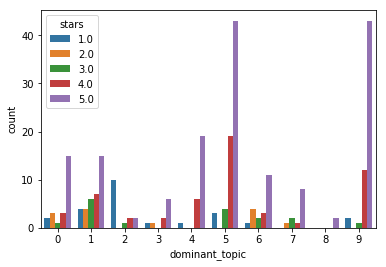

In [62]:
ax = sns.countplot(x='dominant_topic', hue='stars', data=df_document_topic)
#note that the 1-star reviews are clumping in topcs 4, 5, and to a lesser proportion 7
#5 and 7 are also heavy with 2-star reviews

https://pyldavis.readthedocs.io/en/latest/modules/API.html

In [63]:
pyLDAvis.enable_notebook()
dash = pyLDAvis.sklearn.prepare(best_lda_model, data_vectorized, vectorizer, mds='tsne')
dash

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
5     -205.738907  126.888802       1        1  21.816070
9      214.709427 -165.094315       2        1  16.488699
1      -12.350554 -199.071732       3        1  14.785296
4      -50.465916  255.001175       4        1  12.022269
2      255.029037   50.167641       5        1  10.335894
6      -67.828552   17.933640       6        1   8.407921
0       67.279945  120.259674       7        1   7.274561
3      180.545776  250.433594       8        1   4.159295
7       88.608238  -48.019974       9        1   4.077489
8     -192.828568 -104.284554      10        1   0.632506, topic_info=     Category        Freq       Term       Total  loglift  logprob
term                                                              
377   Default   68.000000      table   68.000000  30.0000  30.0000
155   Default  150.000000       good  150.000000  29.0000  29.0000
95    Default   85.000000  delicious   85.000000  28.0000  28.0000
145   Default   37.000000     french   37.000000  27.0000  27.0000
148   Default   50.000000   friendly   50.000000  26.0000  26.0000
260   Default   61.000000      order   61.000000  25.0000  25.0000
389   Default   46.000000      toast   46.000000  24.0000  24.0000
338   Default  124.000000    service  124.000000  23.0000  23.0000
274   Default   35.000000    perfect   35.000000  22.0000  22.0000
270   Default   41.000000      patio   41.000000  21.0000  21.0000
230   Default   59.000000       meal   59.000000  20.0000  20.0000
90    Default   43.000000        day   43.000000  19.0000  19.0000
202   Default   21.000000       lamb   21.000000  18.0000  18.0000
46    Default   60.000000     brunch   60.000000  17.0000  17.0000
334   Default   31.000000       seat   31.000000  16.0000  16.0000
190   Default   27.000000     inside   27.000000  15.0000  15.0000
326   Default   73.000000      salad   73.000000  14.0000  14.0000
371   Default   28.000000     sunday   28.000000  13.0000  13.0000
42    Default   35.000000      bread   35.000000  12.0000  12.0000
15    Default   43.000000        ask   43.000000  11.0000  11.0000
141   Default  174.000000       food  174.000000  10.0000  10.0000
156   Default  109.000000      great  109.000000   9.0000   9.0000
365   Default   32.000000      steak   32.000000   8.0000   8.0000
262   Default   30.000000    outside   30.000000   7.0000   7.0000
225   Default   28.000000     lovina   28.000000   6.0000   6.0000
239   Default   26.000000     minute   26.000000   5.0000   5.0000
327   Default   23.000000     salmon   23.000000   4.0000   4.0000
147   Default   24.000000     friend   24.000000   3.0000   3.0000
199   Default   29.000000       know   29.000000   2.0000   2.0000
112   Default   31.000000        egg   31.000000   1.0000   1.0000
...       ...         ...        ...         ...      ...      ...
56    Topic10    0.791225      charm   10.141274   2.5124  -4.1637
190   Topic10    0.791219     inside   27.457163   1.5164  -4.1638
371   Topic10    0.791231     sunday   28.428328   1.4817  -4.1637
262   Topic10    0.791250    outside   30.131693   1.4235  -4.1637
334   Topic10    0.791229       seat   31.086594   1.3923  -4.1637
148   Topic10    1.233856   friendly   50.849964   1.3445  -3.7194
274   Topic10    0.791234    perfect   35.375281   1.2631  -4.1637
145   Topic10    0.791197     french   37.858934   1.1952  -4.1638
270   Topic10    0.791244      patio   41.631521   1.1002  -4.1637
90    Topic10    0.791226        day   43.750443   1.0506  -4.1637
389   Topic10    0.791197      toast   46.345918   0.9929  -4.1638
230   Topic10    0.791237       meal   59.341426   0.7458  -4.1637
46    Topic10    0.791241     brunch   60.552421   0.7256  -4.1637
260   Topic10    0.791223      order   61.135947   0.7160  -4.1637
162   Topic10    0.071925       half    5.587122   0.7106  -6.5617
425   Topic10    0.071925       wild    5.588

### Let's just do the most positive (4 and 5) and, separately, most negative reviews (1 and 2) - may get more informative clustering there